
# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 7 — Online Gaussian Process Regression

---

Submission by:
* Sam Laing, Matrikelnummer: 6283670
* Albert, Catalan Tatjer, Matrikelnummer: 6443478

Converting to pdf resulted in some terrible plot errors. Also the latex text didn't seem to compile properly: For this reason we submit also the ipynb since it is readable. Apologies. 

In [1]:
# For measuring wallclock time
from time import time

# Numpy, JAX
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers

In [2]:
# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles

%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
plt.rcParams.update(bundles.neurips2023())

In [3]:
# Import `gaussians.py`
import gaussians

### 0. Overview

In this exercise sheet, we are going to implement Gaussian Process (GP) regression in an *online* setting. That means, data arrives sequentially over time and the GP regression model is incrementally updated to incorporate that new information. 

In the lecture and previous exercise sheets, you have already seen and worked with the classes `Gaussian`, `GaussianProcess`, and `ConditionalGaussianProcess` implemented in `gaussians.py`. This functionality is also very straightforward to use in the online setting, but a naive approach will turn out to be prohibitively inefficient. We are going to investigate the underlying problem in more detail and then develop and implement a more efficient strategy by using some tools from linear algebra (like the Schur complement and a block-wise Cholesy factorization).

### 1. Training and Test Data

Since we want to simulate that the training data is provided *incrementally*, it is represented by two lists `X_list` (containing 6 subsets of 100 data points each) and `Y_list` (containing the corresponding regression targets). As a first step, we load the data and visualize these subsets. 

In [4]:
# Load data
data = np.load("data.npz")

# Extract from data
X_list = data["X_list"]
Y_list = data["Y_list"]
sigma = data["sigma"]
X_test = data["X_test"]

In [5]:
# Check shape of sections
print("Training data")
for idx, (Xi, Yi) in enumerate(zip(X_list, Y_list)):
    print(f"Subset index {idx}: X.shape = {Xi.shape}, Y.shape = {Yi.shape}")
    
print("\nTest data")
print("X_test.shape = ", X_test.shape)

Training data
Subset index 0: X.shape = (100, 1), Y.shape = (100,)
Subset index 1: X.shape = (100, 1), Y.shape = (100,)
Subset index 2: X.shape = (100, 1), Y.shape = (100,)
Subset index 3: X.shape = (100, 1), Y.shape = (100,)
Subset index 4: X.shape = (100, 1), Y.shape = (100,)
Subset index 5: X.shape = (100, 1), Y.shape = (100,)

Test data
X_test.shape =  (100, 1)


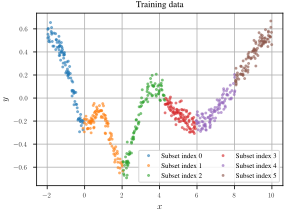

In [6]:
def setup_plot(ax, title=None):
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.grid()
    if title is not None:
        ax.set_title(title)

    
# Visualization of training data
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for idx, (Xi, Yi) in enumerate(zip(X_list, Y_list)):
    ax.plot(Xi, Yi, "o", ms=2, alpha=0.5, label=f"Subset index {idx}")

setup_plot(ax, "Training data")
ax.legend(ncol=2)

plt.show()

### 2. Prior GP

Here, we set up the prior GP with a constant mean at zero and rational quadratic kernel as covariance function.

In [7]:
import functools


def constant_mean(x, c=0.0):
    return c * jnp.ones_like(x[:, 0])


def RQ_kernel(a, b, ell=1.0, alpha=1.0, theta=1.0):
    return theta**2 * (1 + jnp.sum((a - b) / ell, axis=-1) ** 2 / (2 * alpha)) ** (-alpha)

In [8]:
# Define mean, kernel and prior GP
mean = functools.partial(constant_mean, c=0.0)
kernel = functools.partial(RQ_kernel, ell=1.0, alpha=1.0, theta=0.5)
prior = gaussians.GaussianProcess(mean, kernel)

### 3. Approach 1

We can use the functionality implemented in `gaussians.py` to perform inference in an incremental way: In the first step, we condition the prior on the first subset `(X_list[0], y_list[0])`. From this, we obtain an instance of a `ConditionalGaussianProcess` that we can condition on the next subset `(X_list[1], y_list[1])` etc.

In [9]:
def get_posteriors():
    """Construct posteriors from prior by conditioning on subsets"""
    
    posteriors = [prior]
    for posterior_idx, (Xi, Yi) in enumerate(zip(X_list, Y_list)):
        
        # Compute posterior
        posterior = posteriors[-1].condition(Yi, Xi, sigma)
        posteriors.append(posterior)
    posteriors.pop(0)  # remove prior from list
    return posteriors

posteriors_A1 = get_posteriors()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Let's visualize those posteriors.

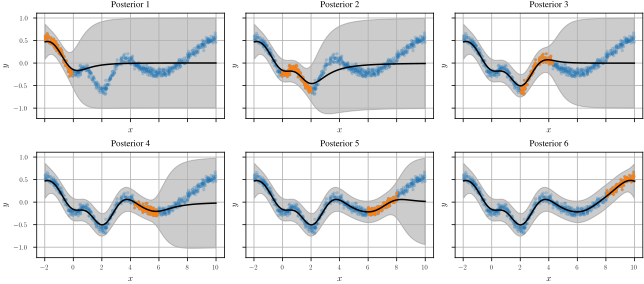

In [10]:
from math import ceil


def get_nrows_ncols(nplots):
    nrows = ceil((1/3) * nplots)
    ncols = ceil(nplots / nrows)
    return nrows, ncols


def plot_conditional_gps(list_of_conditional_gps):
    """Plot a list of conditional GPs in one figure."""
    
    # Concatenate training data
    X = jnp.concatenate(X_list, axis=0)
    Y = jnp.concatenate(Y_list, axis=0)
    
    # Define grid of subplots
    num_gps = len(list_of_conditional_gps)
    nrows, ncols = get_nrows_ncols(num_gps)
    fig, axs = plt.subplots(
        nrows, 
        ncols, 
        figsize=(ncols * 3, nrows * 2),
        sharex=True,
        sharey=True,
    )
    
    # Plot GPs
    for idx, gp in enumerate(list_of_conditional_gps):
        ax = axs.flatten()[idx]

        # Plot GP and data
        ax.plot(X, Y, ".", ms=5, alpha=0.2)
        ax.plot(gp.X, gp.y, ".", ms=3)
        gp.plot(ax, X_test, color="k", std_kwargs={"alpha": 0.2})
        
        setup_plot(ax, f"Posterior {idx + 1}")
    plt.show()
    
plot_conditional_gps(posteriors_A1)

Hm, that took quite some time. Let's investigate the runtime in more detail.

In [11]:
def measure_eval_times(nreps=3):
    """Construct posteriors and measure the time required for evaluating
    them on `X_test`"""
    
    posteriors = [prior]
    eval_times = np.zeros((nreps, len(X_list)))
    for posterior_idx, (Xi, Yi) in enumerate(zip(X_list, Y_list)):
        for rep_idx in range(nreps):
            
            # Measure the time for evaluating the posterior on `X_test`
            start_time = time()
            posterior = posteriors[-1].condition(Yi, Xi, sigma)
            posterior(X_test)
            eval_times[rep_idx, posterior_idx] = time() - start_time
        posteriors.append(posterior)
    
    return eval_times

eval_times_A1 = measure_eval_times()

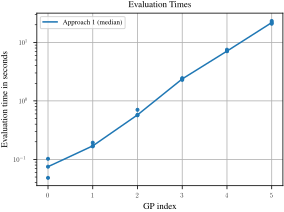

In [12]:
import matplotlib.colors as mcolors
COLS = list(mcolors.TABLEAU_COLORS.values())


def plot_eval_times(list_of_eval_times):
    """Plot the measured evaluation times. Entry 0 in `list_of_eval_times`
    is assumed to belong to approach 1, entry 1 to approach 2 etc.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    for idx, eval_times in enumerate(list_of_eval_times):
        ax.plot(eval_times.T, "o", ms=3, c=COLS[idx])
        label = f"Approach {idx + 1} (median)"
        ax.plot(np.median(eval_times, axis=0), "-", c=COLS[idx], label=label)
    
    # General plot settings
    ax.set_xlabel("GP index")
    ax.set_ylabel("Evaluation time in seconds")
    ax.grid()
    ax.legend()
    ax.set_yscale("log")
    ax.set_title(f"Evaluation Times")

    plt.show()
    
plot_eval_times([eval_times_A1])

In [13]:
# Determine the slopes of the log evaluation time
eval_times_A1_median = np.median(eval_times_A1, axis=0)
slopes = eval_times_A1_median[1:] / eval_times_A1_median[:5]
print("slopes = ", slopes)

slopes =  [2.26728696 3.38916496 4.1171545  2.98927888 3.07020645]


**Observations:** The logarithmic plot shows that the runtime increases approximately exponentially reaching up to 10 seconds (on your machine, it may be different of course) for the last posterior. The runtime increases by a factor of around 3-4 for each additional subset of data. 

**Task:** What's going on here? Why is the runtime increasing approximately exponentially?

**Your answer:** 

Notation: There are B different batches of data, and B updates of the posterior. We will write t._mean, t._covariance, t.prior to reference self._mean, self._covariance, self.prior of the t-th `ConditionalGausianProcess` update. Moreover, t.X denotes the t-th batch of the data. 

python
def _covariance(self, a, b):
    return self.prior.k(a, b) - self.prior.k(
        a, self.X
    ) @ jax.scipy.linalg.cho_solve(
        self.predictive_covariance_cho,
        self.prior.k(self.X, b),
    )


Also, it is clear that, at every step t > 1 (after the first one), t.prior is a `ConditionalGaussianProcess` object.

When we perform inference with X_test at step t, we call Gaussian(mu=t._mean(X_test), Sigma=t._covariance(X_test, X_test). Where we need to compute, t._mean and t._covariance. It is fundamental to note that t._covariance is a function on t.prior.k, t.X. And that t.prior.k is (t-1)._covariance. Now, t._covariance(a, b) is a function of (t-1)._covariance, t.X, a and b. More precisely, it is a function of (t-1)._covariance(a, b), (t-1)._covariance(a, t.X), (t-1)._covariance(t.X, b). So at step t, we need to compute (t-1).covariance 3 times, and perform a cho_solve.

Where:
- (t-1)._covariance(a, b) requires the computation of (t-2)._covariance(a, b), (t-2)._covariance(a, t-1.X), (t-2)._covariance(t-1.X, b)
- (t-1)._covariance(a, t.X) requires the computation of (t-2)._covariance(a, t.X), (t-2)._covariance(a, t-1.X), (t-2)._covariance(t-1.X, t.X)
- (t-1)._covariance(t.X, b) requires the computation of (t-2)._covariance(t.X, b), (t-2)._covariance(t.X, t-1.X), (t-2)._covariance(t-1.X, b)

Until (t-(t-1)).prior.k, which is the initial `Gaussian` object.
As can be seen, the computations branches out as a ternary tree which, by its very definition, is an exponential runtime. 

### 4. Approach 2

Here, we condition the prior on a growing data set. For this, we overwrite the `condition` method of the `ConditionalGaussianProcess` class.

In [14]:
from gaussians import Gaussian, ConditionalGaussianProcess


def condition_on_prior(self, y_new, X_new, sigma):
    
    # Check data
    y_new = jnp.atleast_1d(y_new)
    X_new = jnp.atleast_2d(X_new)

    # Concatenate data
    X_both = jnp.concatenate([self.X, X_new], axis=0)
    y_both = jnp.concatenate([self.y, y_new], axis=0)
    
    # Concatenate Gaussians 
    mu_new = jnp.zeros_like(y_new)
    mu_both = jnp.concatenate([self.epsilon.mu, mu_new], axis=0)
    
    Sigma_new = sigma * jnp.eye(len(y_new))
    Sigma_both = jax.scipy.linalg.block_diag(self.epsilon.Sigma, Sigma_new)
    
    epsilon_both = Gaussian(mu=mu_both, Sigma=Sigma_both)

    # Build conditional GP from prior (!)
    return ConditionalGaussianProcess(self.prior, y=y_both, X=X_both, epsilon=epsilon_both)

# Assign method to class
ConditionalGaussianProcess.condition = condition_on_prior

In [15]:
# Evaluate approach 2
posteriors_A2 = get_posteriors()
eval_times_A2 = measure_eval_times()

**Note:** In theory, you can show that the posteriors from approaches 1 and 2 are identical, i.e. conditioning multiple times in a convoluted manner (approach 1) is equivalent to conditioning on the union of the subsets (approach 2). Let's check if we can confirm this claim empirically.

**Task:** Evaluate the posteriors on `X_test` and check if the resulting Gaussian distributions are identical (`jnp.allclose` might be useful here).

In [16]:
# Two Gaussians are identical if both their respective mean and covariance are identical
# define a function to compare these and then compare the posteriors from A1 and A2 evaluated on X_test
def compare_posteriors(p1, p2):
    if (jnp.allclose(p1(X_test).mu, p2(X_test).mu)) and (
        jnp.allclose(p1(X_test).Sigma, p2(X_test).Sigma)
    ):
        return True
    return False


compare_posteriors(posteriors_A1[0], posteriors_A2[0])

for i, (p1, p2) in enumerate(zip(posteriors_A1, posteriors_A2)):
    print(
        f"comparison of the posteriors for batch {i} of the dataset results in {compare_posteriors(p1,p2)}"
    )

comparison of the posteriors for batch 0 of the dataset results in True
comparison of the posteriors for batch 1 of the dataset results in True
comparison of the posteriors for batch 2 of the dataset results in True
comparison of the posteriors for batch 3 of the dataset results in True
comparison of the posteriors for batch 4 of the dataset results in True
comparison of the posteriors for batch 5 of the dataset results in True


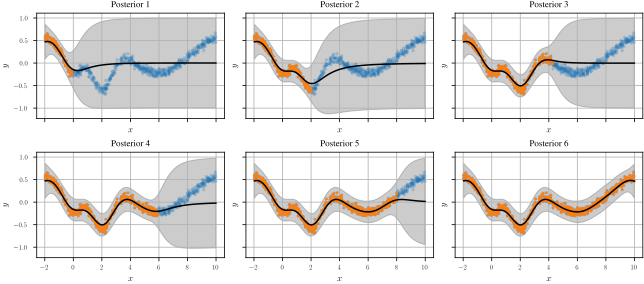

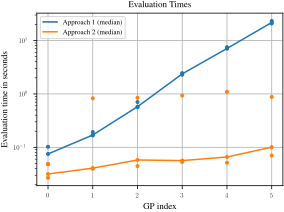

In [17]:
# Visualizations
plot_conditional_gps(posteriors_A2)
plot_eval_times([eval_times_A1, eval_times_A2])

### 5. Approach 3

While approach 2 is less inefficient, it is still quite wasteful: For every new subset, the posterior GP is built entirely from scratch! This can be improved by exchanging information between the posteriors: Simply put, a posterior that is conditioned on some data set should inform the next posterior what it has already learned about the data. Before we dive into that, we need to get the theory straight.

Our goal is to condition the GP on a data set $(X, y)$ that is the union of $(X_{old}, y_{old})$ and $(X_{new}, y_{new})$. Let's assume that we have conditioned a GP on $(X_{old}, y_{old})$ and have already triggered the computation of its properties. So, in particular, the following quantities are already cached:

1. `predictive_covariance`: $k(X_{old}, X_{old}) + \sigma^2 I$
2. `predictive_mean`: $m(X_{old}) + \mu(X_{old})$
3. `predictive_covariance_cho`: the Cholesky factorization of `predictive_covariance`
4. `representer_weights`: $[k(X_{old}, X_{old}) + \sigma^2 I]^{-1} (y_{old} - m(X_{old}) + \mu(X_{old}))$

**Improved version:** Now, the core idea is to use the quantities above to save computations when conditioning on $(X, y)$.

5. `predictive_covariance`: This matrix now has the following block structure:
$$
k(X, X) + \sigma^2 I 
= 
\left(
\begin{array}{@{}c|c@{}}
k(X_{old}, X_{old}) + \sigma^2 I 
& 
k(X_{old}, X_{new}) \\
\hline
k(X_{new}, X_{old})
& 
k(X_{new}, X_{new}) + \sigma^2 I 
\end{array}
\right)
=: 
\left(
\begin{array}{@{}c|c@{}}
A & B \\ \hline C & D
\end{array}
\right).
$$
If we have already conditioned on $(X_{old}, X_{old})$, block $A$ was already computed (see 1. above) and we only have to evaluate the remaining blocks $B$, $C$ and $D$.
6. `predictive_mean`: The predictive mean also splits into two parts 
$$
m(X) + \mu(X)
= 
\begin{pmatrix}
  m(X_{old}) + \mu(X_{old}) \\
\hline
  m(X_{new}) + \mu(X_{new})
\end{pmatrix}
=:
\begin{pmatrix}
  a \\ \hline b
\end{pmatrix}.
$$
Note that $a$ was already computed, see 2. above.
7. `predictive_covariance_cho`: In order to compute a Cholesky factorization of $k(X, X) + \sigma^2 I$, we can use that we already have the Cholesky factor $A^{1/2}$ of $A$, see 3. above. It should be clear from theory exercise 1 (b) on the current exercise sheet how to construct the Cholesky factor for $k(X, X) + \sigma^2 I$.
8. `representer_weights`: We already computed the representer weights $A^{-1} \cdot u$, with $u = y_{old} - a$, see 4. above. Now, we have to solve a larger linear system
$$
\left(
\begin{array}{@{}c|c@{}}
A & B \\ \hline C & D
\end{array}
\right)
\cdot 
\begin{pmatrix}
  x \\ \hline y
\end{pmatrix}
= 
\begin{pmatrix}
  u \\ \hline v
\end{pmatrix}
$$
with $v = y_{new} - b$ and the unknowns $x$ and $y$. After computing $v$, $y$ and $x$ are given by
\begin{align}
y &= Q^{-1} (v - C A^{-1} u) \\
x &= A^{-1}u - A^{-1} B y,
\end{align}
where $Q = D - C A^{-1} B$ is the so-called [Schur-complement](https://en.wikipedia.org/wiki/Schur_complement#Application_to_solving_linear_equations). Note: All necessary quantities (like $Q^{1/2}$ and $A^{-1} u$) were already computed in previous steps.

**Task:** Implement an improved version of the condition method that constructs 5, 6, 7, and 8. Try to make this as efficient as possible by using the quantities 1, 2, 3, and 4. Make sure that the resulting posteriors are the same as the ones from approach 2 (e.g. by evaluating them on the same test data and comparing the Gaussians).

Comparing posteriors for after adding batch 0 gives True
Comparing posteriors for after adding batch 1 gives True
Comparing posteriors for after adding batch 2 gives True
Comparing posteriors for after adding batch 3 gives True
Comparing posteriors for after adding batch 4 gives True
Comparing posteriors for after adding batch 5 gives True


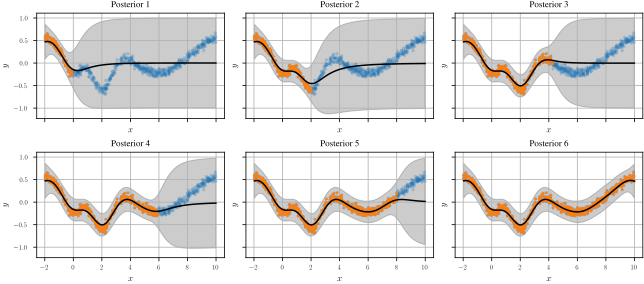

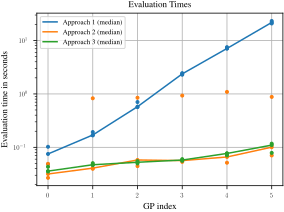

In [18]:
from gaussians import Gaussian, ConditionalGaussianProcess


def condition_on_prior_improved(self, y_new, X_new, sigma):
    # Check data
    y_new = jnp.atleast_1d(y_new)
    X_new = jnp.atleast_2d(X_new)

    # Concatenate data
    X_both = jnp.concatenate([self.X, X_new], axis=0)
    y_both = jnp.concatenate([self.y, y_new], axis=0)

    # Concatenate Gaussians
    mu_new = jnp.zeros_like(y_new)
    mu_both = jnp.concatenate([self.epsilon.mu, mu_new], axis=0)

    Sigma_new = sigma * jnp.eye(len(y_new))
    Sigma_both = jax.scipy.linalg.block_diag(self.epsilon.Sigma, Sigma_new)

    epsilon_both = Gaussian(mu=mu_both, Sigma=Sigma_both)

    # Build conditional GP from prior (!)
    cond_gp = ConditionalGaussianProcess(
        self.prior, y=y_both, X=X_both, epsilon=epsilon_both
    )

    A_sqrt = self.predictive_covariance_cho
    B = self.prior.k(self.X[:, None, :], X_new[None, :, :])
    C = B.T
    D = self.prior.k(X_new[:, None, :], X_new[None, :, :]) + Sigma_new

    # ===========================================
    # 5. predictive_covariance
    # ===========================================
    cond_gp.predictive_covariance = jnp.block([[self.predictive_covariance, B], [C, D]])

    # ===========================================
    # 6. predictive_mean
    # ===========================================
    b = self.prior.m(X_new) + mu_new
    cond_gp.predictive_mean = jnp.hstack([self.predictive_mean, b])

    # ===========================================
    # 7. predictive_covariance_cho
    # ===========================================
    A_inv = jax.scipy.linalg.cho_solve(
        self.predictive_covariance_cho, jnp.eye(self.predictive_covariance.shape[0])
    )
    Q = D - C @ A_inv @ B
    Q_cho = jax.scipy.linalg.cho_factor(Q)
    cho12 = jax.scipy.linalg.solve_triangular(
        self.predictive_covariance_cho[0].T, B, lower=True
    )
    cond_gp.predictive_covariance_cho = (
        jnp.block([[A_sqrt[0], cho12], [jnp.zeros_like(C), Q_cho[0]]]),
        False,
    )

    # ===========================================
    # 8. representer_weights
    # ===========================================
    v = y_new - b
    y = jax.scipy.linalg.cho_solve(Q_cho, v - C @ self.representer_weights)
    x = self.representer_weights - A_inv @ (B @ y)
    cond_gp.representer_weights = jnp.hstack([x, y])

    return cond_gp


# Assign method to class
ConditionalGaussianProcess.condition = condition_on_prior_improved

# Evaluate approach 3
posteriors_A3 = get_posteriors()
eval_times_A3 = measure_eval_times()

# Make sure that the posteriors are identical to the ones from approach 2
for i, (p2, p3) in enumerate(zip(posteriors_A2, posteriors_A3)):
    print(
        f"Comparing posteriors for after adding batch {i} gives {compare_posteriors(p2, p3)}"
    )  # Visualizations


plot_conditional_gps(posteriors_A3)
plot_eval_times([eval_times_A1, eval_times_A2, eval_times_A3])